In [1]:
import numpy as np
import ctypes
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import fdrcorrection_twostage as fdr
import os
import argparse
import time
import matplotlib.pyplot as plt
from iotools.dosageparser import DosageParser
from iotools.readVCF import ReadVCF 
from scipy.optimize import minimize
from scipy.special import erfinv
#from inference.regulizer_optimizer import OptimizeRegularizer
from inference.perm_regulizer_optimizer import OptimizeRegularizer
#from select_genes_per_snp import linear_reg
import regstat
import regnull
import hist_qq
#from qqplot import plot_hist_qq

In [2]:
def read_expression(filename):
    gene_names = list()
    expression = list()
    with open(filename, 'r') as genefile:
        header = genefile.readline()
        donorids = header.strip().split("\t")[1:]
        for line in genefile:
            linesplit = line.strip().split("\t")
            expression.append(np.array(linesplit[1:], dtype=float))
            gene_names.append(linesplit[0])
    expression = np.array(expression)
    return donorids, expression, gene_names


'''def norm_binom(genotype, f):
    genotype = (genotype - (2 * f)) / np.sqrt(2 * f * (1 - f))
    return genotype
'''

def parse_geno (genotype_filename, sample_filename, startsnp, endsnp):                              #Read genotype here
    ds        = DosageParser(genotype_filename, sample_filename, startsnp, endsnp)
    dosage    = ds.dosage
    snpinfo   = ds.snpinfo
    donorids  = ds.sample_id
    nsnps     = ds.nsnps
    nsample   = ds.nsample
    return dosage, snpinfo, donorids, nsnps, nsample

                                                                                                    #quality check, matching
def quality_check ( sampleids, donorids):
    choose_ids     = [x for x in donorids if x in sampleids]
    #dosage_indices = [i for i, x in enumerate(donorids)  if x in choose_ids]
    #exprsn_indices = [i for i, x in enumerate(sampleids) if x in choose_ids]
    dosage_indices = [donorids.index(i) for i in choose_ids]
    exprsn_indices = [sampleids.index(i) for i in choose_ids]
    return dosage_indices, exprsn_indices

def read_distance(filename):
    samplelist = list()
    distances = list()
    with open(filename, 'r') as mfile:
        mfile.readline()
        for line in mfile:
            linestrip = line.strip().split("\t")
            samplelist.append(linestrip[0])
            distances.append(np.array(linestrip[1:],dtype=float))
    return np.array(distances), samplelist

In [3]:
#out_fileprefix      = 
genotype_filename   = "data/geno/GTEx_450Indiv_genot_imput_info04_maf01_HWEp1E6_dbSNP135IDs_donorIDs_dosage_chr2.gz"
sample_filename     = "data/geno/donor_ids.fam"
#expression_filename = "/home/raktim/Documents/tejaas/final/PCA_KNN_Correction/main/expr2.txt"
expression_filename = "Whole_Blood_Analysis.v6p.normalized.expression.txt"

startsnp            = 1
endsnp              = 10000
optim               = 0
#user_sigbeta        = 0.001636581825407
#transgeno           = "data/GTEx_450Indiv_genot_imput_info04_maf01_HWEp1E6_dbSNP135IDs_donorIDs_dosage_filteredTEJAAS_transeqtls.gz"#opts.trans_genofile

In [4]:
sampleids, expression, gene_names = read_expression(expression_filename)

In [5]:
dosage, snpinfo, donorids, nsnps, nsample = parse_geno ( genotype_filename, sample_filename, startsnp, endsnp)
dosage_indices, exprsn_indices = quality_check (sampleids , donorids)
conv_dosage = np.round(dosage)


low maf  poly alleles  complement alleles 

3427   846   1356 

Total SNPs read in :  10000
Total SNPs remained :  4371



In [6]:
expr = expression[:, exprsn_indices]
#expr = np.random.normal(0, 1, 23973 * 338).reshape(23973, 338)
geno = conv_dosage[:, dosage_indices]
expr = (expr - np.mean(expr, axis = 1).reshape(-1, 1)) / np.std(expr, axis = 1).reshape(-1, 1)
print ("Completed data loading and processing\n")

Completed data loading and processing



In [126]:
# idx = np.random.permutation(np.arange(0, geno.shape[0]))[:5000]
# geno_nold = geno[idx, :]
# geno = geno_nold

In [127]:
# ##shuffling
# geno_shuffled = np.zeros_like(geno)
# for i in range(geno.shape[0]):
#     idx = np.random.permutation(np.arange(0, geno.shape[1]))
#     geno_shuffled[i, :] = geno[i, idx]
# geno = geno_shuffled

In [128]:
# #knn 
# choose_ids = [x for x in sampleids if x in donorids]
# distance, sample = read_distance("PCA_KNN_Correction/main/sample_distance_matrix.csv")
# distance_matrix = distance[exprsn_indices,:][:,exprsn_indices]

# k=2
 

# # corrected_geno = np.zeros_like(geno)
# # for i,j in enumerate(choose_ids):
# #     distances = distance_matrix[i,:]
# #     neighbors =np.argsort(distances)[: k+1]
# #     corrected_geno[:, i] = geno[:, i] - np.mean(geno[:, neighbors[1:]], axis = 1)

# # geno = corrected_geno

In [7]:
geno = (geno.T - np.mean(geno.T,axis = 0)).T

In [33]:
sigmabeta = 0.0005
sigmabeta2 = sigmabeta**2
#sigmax2 = np.var(geno,axis = 1)
sigmax2 = np.var(geno - np.mean(geno, axis=0),axis = 1)
tic = time.time()
U, S, Vt = np.linalg.svd(expr.T, full_matrices=False)
Rscore_sb001, S_sb001, pvals_sb001 = regstat.rscore(geno, expr, sigmabeta2, sigmax2, svd_corr = False)

In [54]:
sigmabeta = 0.0001
sigmabeta2 = sigmabeta**2
#sigmax2 = np.var(geno,axis = 1)
sigmax2 = np.var(geno - np.mean(geno, axis=0),axis = 1)
tic = time.time()
U, S, Vt = np.linalg.svd(expr.T, full_matrices=False)
Rscore_sb0006, S_sb0006, pvals_sb0006 = regstat.rscore(geno, expr, sigmabeta2, sigmax2, svd_corr = False)

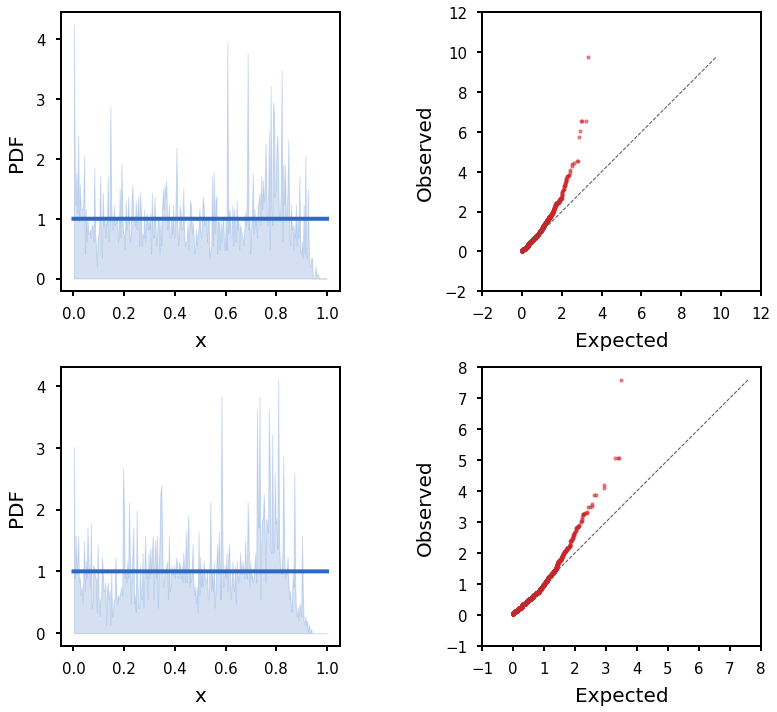

In [55]:
## Plot

fig = plt.figure(figsize = (12, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


nbins = 300
sizefactor = 1
hist_qq.plot(ax1, ax2, pvals_sb001, nbins, 'uniform', loc = 0, scale = 1, size = sizefactor)
hist_qq.plot(ax3, ax4, pvals_sb0006, nbins, 'uniform', loc = 0, scale = 1, size = sizefactor)


plt.tight_layout()
plt.show()

In [59]:
dum = np.argsort(pvals_sb001)
rank_sb001 = np.zeros_like(pvals_sb001)
rank_sb001[dum] = np.arange(pvals_sb001.shape[0])

dum = np.argsort(pvals_sb0006)
rank_sb0006 = np.zeros_like(pvals_sb0006)
rank_sb0006[dum] = np.arange(pvals_sb0006.shape[0])

/home/raktim/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


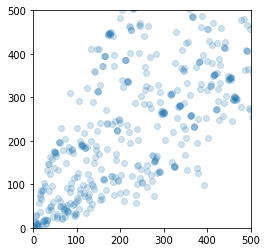

In [60]:
plt.figure()
plt.scatter(rank_sb001, rank_sb0006, alpha = 0.2)#, s = 0.6)
plt.axes().set_aspect('equal')
plt.xlim([0, 500])
plt.ylim([0, 500])
plt.show()

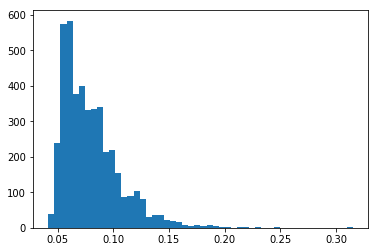

In [58]:
plt.figure()
plt.hist(Rscore_sb0006, bins = 50)
plt.show()